In [3]:
import os
import numpy as np
import rasterio
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
from rasterio.transform import Affine

In [6]:
def slum_resample(input_raster, output_raster, scale_factor):
    with rasterio.open(input_raster) as src:
        data = src.read(1)  # 读取第一个波段
        profile = src.profile

        # 检查数据中的唯一值
        unique_values = np.unique(data)
        print("Unique values in the data:", unique_values)

        # 显示原始数据（灰度）
        plt.figure(figsize=(12, 10))
        plt.title("Original Data")
        im = plt.imshow(data, cmap='gray')
        cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], shrink=0.75, pad=0.04)  # 调整这里的参数以合理化颜色条的尺寸
        cbar.ax.set_yticklabels(['Background', 'Non Builtup', 'Formal Builtup', 'Informal Builtup'])
        plt.show()

        # 计算新维度
        new_height = data.shape[0] // scale_factor
        new_width = data.shape[1] // scale_factor

        # 创建一个新数组以存储重采样后的数据，并初始化为背景值
        resampled_data = np.full((new_height, new_width), -1, dtype=np.int8)

        # 处理每个8x8块
        for i in range(new_height):
            for j in range(new_width):
                block = data[i*scale_factor:(i+1)*scale_factor, j*scale_factor:(j+1)*scale_factor]
                # 过滤背景值
                valid_pixels = block[block >= 1]  # 假设1及以上为有效类别
                # 计算 class 3（非正规建筑区）像素的数量
                num_class_3 = np.sum(valid_pixels == 3)
                # 应用多数法则
                if len(valid_pixels) > 0:  # 确保块中有有效像素
                    if num_class_3 > len(valid_pixels) / 2:
                        resampled_data[i, j] = 1  # 标记为 slum
                    else:
                        resampled_data[i, j] = 0  # 标记为 non slum

        # 显示降采样后的数据（灰度），用不同颜色标记背景
        plt.figure(figsize=(12, 10))
        plt.title("Resampled Data")
        im_resampled = plt.imshow(resampled_data, cmap='gray', vmin=-1, vmax=1)
        cbar = plt.colorbar(im_resampled, ticks=[-1, 0, 1])  # 同样调整这里的参数
        cbar.ax.set_yticklabels(['Background', 'Non Slum', 'Slum'])
        plt.show()

        # 更新新的分辨率，调整转换矩阵以反映新的分辨率
        transform = src.transform * Affine.scale(scale_factor)

        profile.update(
            dtype=rasterio.int8,
            height=new_height,
            width=new_width,
            transform=transform,
            nodata=-1  # 设置背景值为nodata
        )

        # 写入重采样后的数据
        with rasterio.open(output_raster, 'w', **profile) as dst:
            dst.write(resampled_data, 1)

Unique values in the data: [0 1 2 3]


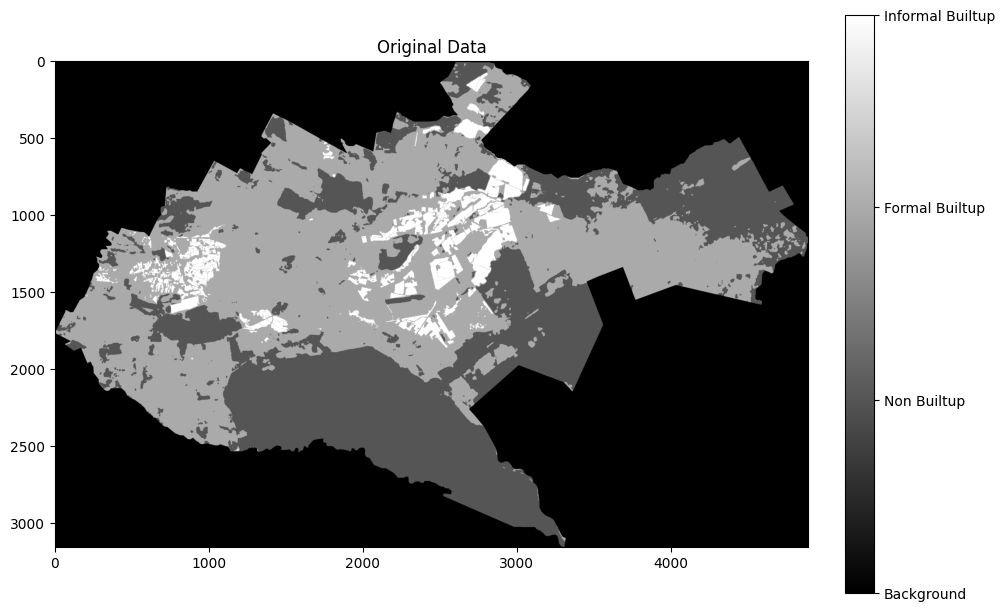

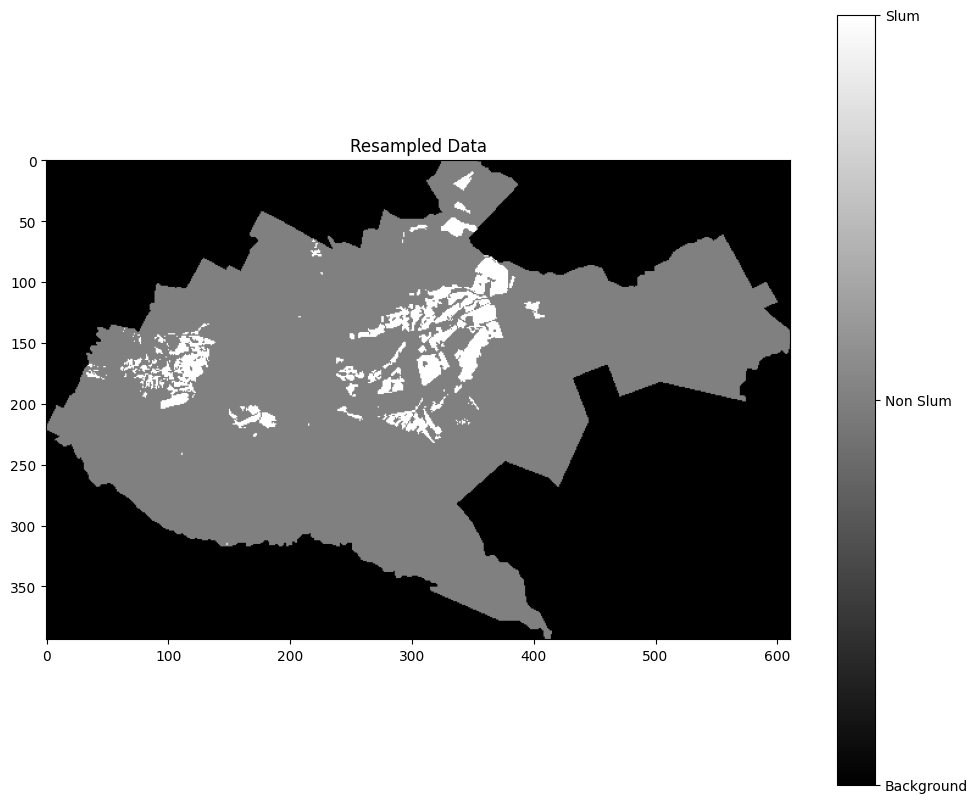

In [7]:
ROOT_DIR = '/home/jovyan/private/Research_thesis/Satellite_branch/'
LABEL_FILE = os.path.join(ROOT_DIR, "Nrb_reference_new3857.tif")
output_raster = os.path.join(ROOT_DIR, "Nrb_reference_resampled_80m.tif")
scale_factor = 8  # 80m / 10m

slum_resample(LABEL_FILE, output_raster, scale_factor)

In [6]:
import rasterio
import os

ROOT_DIR = '/home/jovyan/private/Research_thesis/Satellite_branch/'
LABEL_FILE = os.path.join(ROOT_DIR, "Nrb_reference_new3857.tif")
output_raster = os.path.join(ROOT_DIR, "Nrb_reference_resampled_80m.tif")
with rasterio.open(output_raster) as src:
    # 读取第一个波段的数据
    data = src.read(1)
    
    # 获取唯一值
    unique_values = np.unique(data)

# 打印唯一值
print("Unique values in the resampled TIFF file:", unique_values)

Unique values in the resampled TIFF file: [-1  0  1]
